# Матчинг товаров с помощью библиотеки FAISS

Матчинг — это процесс поиска и сопоставления объектов внутри датасета (т. е. поиска match'ей). Он позволяет решать различные задачи — например, сворачивать одинаковые предложения в одну карточку товара на маркетплесах, строить систему рекомендаций и др.

В данном проекте мы будем искать матчи для товаров из запроса среди товаров, уже имеющихся в базе. В нашем распоряжении имеются следующие данные:

- `base.csv` — векторное представление товаров;
- `train.csv` — обучающая выборка: векторное представление товаров из запроса (query) и таргет, указывающий какой товар их базы является матчем;
- `test.csv` — тестовая выборка: векторное представление товаров из запроса, для которых нужно найти матч в base.


Для решения задачи матчинга мы применим векторный поиск с помощью библиотеки FAISS. FAISS — Facebook AI Research Similarity Search – это разработка команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss


from sklearn.preprocessing import StandardScaler
from faiss import normalize_L2
from catboost import CatBoostClassifier

from tqdm import tqdm
import gc

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot') # устанавливаем стиль графиков
plt.rcParams["figure.figsize"] = (20,20)

## Загрузка и обзор данных

### Загрузка

In [2]:
base = pd.read_csv('base.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Первым делом рассмотрим объемный датасет с информацией (в векторном виде) обо всех товарах.

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

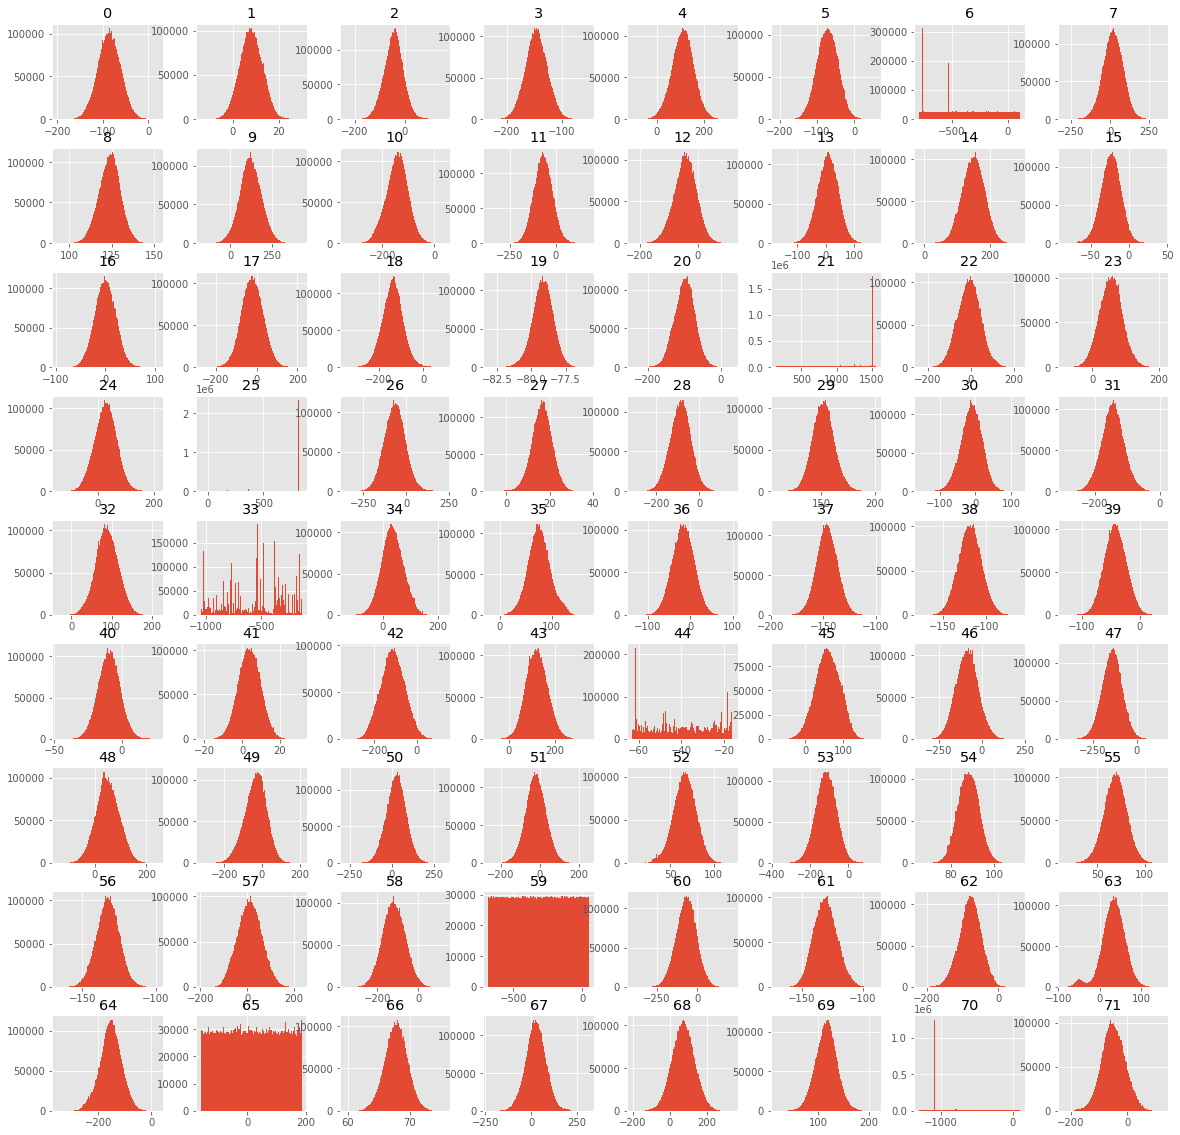

In [4]:
base.hist(bins=100);

In [5]:
base.shape

(2918139, 73)

И так, в нашем распоряжении данные о почти 3 млн товарах. Товары "размещены" в 72 мерном пространстве — первый признак представляет собой `Id` товара. Все векторные признаки имеют тип данных `float64`, и в настоящий момент датасет потребляет 1.6 Гб памяти.

На графике распределения признаков видно:  
- есть признаки, которые распределены нормально и которые распределены ненормально;
- средние значения и отклонения у нормально распределённых признаков разные (необходима нормализация);
- средние значения у ненормально распределённых признаков также отличаются => возможно, тоже стоит использовать StandardScaler;
- у некоторых ненормально распределённых признаков есть значения, встречающиеся чаще других.

In [6]:
base.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [7]:
base.sample(5)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
2800712,4480175-base,-83.905320,-7.224893,-19.648012,-132.98322,58.289580,-29.693604,-390.349910,59.334120,121.539246,...,-63.074790,53.565674,-139.95525,-0.296099,71.006996,-15.498171,36.405876,87.75858,-424.749461,-77.253180
1893021,2649267-base,-85.270730,8.912687,-41.225410,-129.55391,26.064468,-91.007780,-164.634559,27.182236,125.416630,...,-69.010060,24.680843,-186.42297,-75.379067,66.412800,75.985460,6.105866,121.42791,-235.918280,-91.243240
194232,202571-base,-78.556990,1.843463,-52.975636,-125.17652,176.810290,-32.497460,-275.285665,-13.718817,125.982350,...,-19.821045,50.977592,-135.23440,-43.222156,66.553910,32.507244,71.613090,107.00803,-861.984518,-1.730206
282603,299993-base,-75.292816,8.980313,-49.574635,-155.93169,127.526560,-67.319626,-530.124724,-4.232470,115.145424,...,-130.376300,31.225882,-168.01405,146.852109,67.215100,227.838960,78.614310,132.64496,-1206.160895,-14.927624
666085,761340-base,-97.933740,0.514164,-87.975235,-167.97838,161.821370,-14.249622,-159.022611,77.359430,119.846820,...,-93.900870,33.330383,-189.78130,171.000546,67.533750,23.135483,54.996883,141.07500,-71.520089,-43.828472


При взгляде на первые строки могло показаться, что индекс совпадает с числовым суффиксом товара, однако, выборка 5 случайных объектов позволяет определить, что это не так.

### Нормализация данных

In [8]:
# отделим нормально и ненормально распределенные признаки
# отделим первый признак с индексом

not_normed = ['6', '21', '25', '33', '44', '59', '65', '70']
normed = [col for col in base.columns[1:] if col not in not_normed]

In [9]:
# ко всем колонкам кроме Id применяем StandardScaler

scaler = StandardScaler()

base_scaled = pd.DataFrame(scaler.fit_transform(base[normed + not_normed]),
                           columns=normed + not_normed)
base_scaled = pd.concat([base[['Id']], base_scaled], axis=1)

In [10]:
# применяем нормализацию ко всем датасетам

train_scaled = pd.DataFrame(scaler.transform(train[normed + not_normed]),
                            columns=normed + not_normed)
train_scaled = pd.concat([train[['Id', 'Target']], train_scaled], axis=1)



test_scaled = pd.DataFrame(scaler.transform(test[normed + not_normed]),
                           columns=normed + not_normed)
test_scaled = pd.concat([test[['Id']], test_scaled], axis=1)

### Признаки с "ненормальным" распределением

Осталось немного подумать над признаками с неномральным распределением. Вероятно, за ними скрываются категориальные признаки. Посмотрим на совпадение этих признаков у товаров и их матчей с помощью размеченного датасета train.

In [11]:
train_analyze = train_scaled[['Id', 'Target'] + not_normed]
train_analyze = pd.merge(train_analyze,
                         base_scaled[['Id'] + not_normed].rename(columns={'Id': 'Target'}),
                         on='Target',
                         suffixes=('_query', '_base'))

# добавим флаги равенства
for col in not_normed:
    train_analyze[col] = (train_analyze[f'{col}_query'] == train_analyze[f'{col}_base']).astype(int)
    
train_analyze = train_analyze[['Id', 'Target'] + not_normed]

In [12]:
train_analyze.head()

,Id,Target,6,21,25,33,44,59,65,70
0,0-query,675816-base,1,0,1,0,0,0,0,1
1,1-query,366656-base,0,0,1,0,1,0,0,0
2,2-query,1447819-base,1,0,1,0,1,0,0,1
3,3-query,1472602-base,1,1,1,0,1,0,0,0
4,4-query,717819-base,1,1,1,0,1,0,1,1


In [13]:
for col in not_normed:
    print(col, train_analyze[col].sum() / train_analyze.shape[0])

6 0.64986
21 0.56723
25 0.79395
33 0.0
44 0.64752
59 0.0
65 0.29132
70 0.71878


`6`, `25`, `44` и `70` признаки у товаров из запроса и их матчей совпадают достаточно часто, но 100% корреляции очевидно нет.

### Понижение размерности

#### base_scaled

In [14]:
base_scaled_obj = base_scaled.select_dtypes(include=['object'])

In [15]:
base_scaled_num = base_scaled.select_dtypes(include=['float64']).astype('float32')

In [16]:
base_scaled = pd.concat([base_scaled_obj[['Id']], base_scaled_num], axis=1)

In [17]:
gc.collect()

703484

#### train_scaled

In [18]:
train_scaled.head()

,Id,Target,0,1,2,3,4,5,7,8,...,69,71,6,21,25,33,44,59,65,70
0,0-query,675816-base,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,...,0.906575,0.522963,0.165148,-0.897816,0.421591,0.959996,0.533131,1.640425,-1.173481,0.995267
1,1-query,366656-base,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,-1.538329,0.193777,...,0.709459,-0.083491,1.095696,-2.261146,0.421591,1.273264,1.428186,-0.672895,-0.159574,-0.611690
2,2-query,1447819-base,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,-0.791080,0.328335,...,0.300576,0.604677,1.543015,0.624318,0.421591,-1.781359,0.650926,0.726148,0.687136,-0.713847
3,3-query,1472602-base,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,0.916179,0.050167,...,0.128028,0.668019,-1.409605,0.624318,0.421591,-1.781359,0.610954,-0.300219,0.806859,-0.713847
4,4-query,717819-base,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.399148,0.355099,...,-1.090276,0.638160,0.261015,0.624318,0.421591,-0.868174,-0.904568,0.535832,-1.331745,-0.713847


In [20]:
train_scaled.select_dtypes(include=['object'])

,Id,Target
0,0-query,675816-base
1,1-query,366656-base
2,2-query,1447819-base
3,3-query,1472602-base
4,4-query,717819-base
...,...,...
99995,99995-query,811868-base
99996,99996-query,1460772-base
99997,99997-query,2366140-base
99998,99998-query,9252-base


In [21]:
train_scaled_obj = train_scaled.select_dtypes(include=['object'])
train_scaled_num = train_scaled.select_dtypes(include=['float64']).astype('float32')
train_scaled = pd.concat([train_scaled_obj, train_scaled_num], axis=1)


gc.collect()

60

#### test_scaled

In [26]:
test_scaled_obj = test_scaled.select_dtypes(include=['object'])
test_scaled_num = test_scaled.select_dtypes(include=['float64']).astype('float32')
test_scaled = pd.concat([test_scaled_obj, test_scaled_num], axis=1)


gc.collect()

30

## Векторный поиск с Faiss

Для поиска матчей воспользуемся Inverted File index из FAISS. Количество кластеров определим как квадратный корень из `base`.

In [28]:
# сохраним словарь с айдишниками base
id_base_dict = dict(base_scaled['Id'])

### Поиск по расстоянию L2

In [29]:
base_dict = pd.DataFrame(base_scaled['Id'], index = base_scaled.index) # делаем новый датафрейм с индексом и ID
base_dict.to_csv("base_dict.csv", index=False)                         # сохраним словарь в csv,
                                                                       # в случае проблем с памятью переменную можно будет удалить
                                                                       # а потом прочитать заново

In [30]:
n_clusters = np.sqrt(len(base)).round()

In [31]:
n_clusters

1708.0

In [32]:
dim = 72  # размерность пространства
k = 1708  # количество центров
quantiser = faiss.IndexFlatL2(dim) 
index = faiss.IndexIVFFlat(quantiser, dim, k)

In [35]:
base_scaled_i = base_scaled.drop(columns=['Id'])

In [36]:
%%time

index = faiss.index_factory(dim, 'IVF1708,Flat')
index.train(base_scaled_i)

print(index.is_trained)  
print(index.ntotal)   
index.add(base_scaled_i)
print(index.ntotal)

True
0
2918139
Wall time: 1min 4s


In [41]:
test_scaled_i = test_scaled.drop(columns=['Id'])

In [43]:
%%time
topn = 100 # количество ближайших товаров-векторов, которые могут оказаться матчем
index.nprobe = 100  # Проходим по топ-100 центроид для поиска top-n ближайших соседей
D, I = index.search(test_scaled_i, topn)

Wall time: 5min 35s


In [44]:
I.shape

(100000, 100)

In [45]:
I

array([[2192372, 2177660,  342838, ...,  896536,  406458,  201875],
       [ 157966,   11829,  847800, ...,  154717,   63166,  421028],
       [ 431806,  148400,  451870, ..., 2648564, 2012223,  927592],
       ...,
       [1392746,  349609,  699739, ...,  182570, 1663612, 1660192],
       [ 319526, 2820290, 2253420, ...,  968369, 2415330, 2244741],
       [2888788, 2505458,  330927, ...,  686206, 1879223,  483919]],
      dtype=int64)

In [48]:
test_dict = pd.DataFrame(test_scaled['Id'], index = test_scaled.index) # делаем новый датафрейм с индексом и ID

In [49]:
predicted_list = []
for candidates in I:
    predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))
    
#формируем ответ
answer = test_dict[['Id']]
answer['Predicted'] = predicted_list

answer.to_csv('submission_scaled_100.csv', index=False)

Текущий сабмит дает метрику recall@10 0.69 (проверка внешняя путем отпарвки сабмита), и дальшейшее улучшение работы связано с использованием тренировочных данных для переранжирования ближайших векторов, найженных с помощью Faiss.
